In [4]:
import sys
import os
os.chdir("/home/jonfrey/ASL")
sys.path.append("""/home/jonfrey/ASL/src/""")
sys.path.append("""/home/jonfrey/ASL/src/pseudo_label""")

import numpy as np
from visu import Visualizer
import imageio


# STD
import os
import copy

# MISC
import numpy as np
import torch
import imageio
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.patches as patches

In [5]:
from PIL import Image
import cv2
import torch
from torchvision import transforms as tf
from utils_asl import LabelLoaderAuto

lla = LabelLoaderAuto(root_scannet="/home/jonfrey/Datasets/scannet")

In [56]:
from pathlib import Path
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
class AccMonitor():
    def __init__(self):
        self.metrics = {}
        self.metric_dict = {'correct': 0,
                            'correct_valid': 0,
                            'correct_valid_both': 0,
                            'total': 0, 
                            'total_valid':0,
                            'total_valid_both':0,
                            'images': 0,
                            'confusion': np.zeros((40,40))}
    def register(self,name):
        self.metrics[name] = copy.deepcopy(self.metric_dict)
        
    def update(self,name, label, gt):
        if name not in self.metrics.keys():
            self.register(name)
        m1 = gt != -1
        self.metrics[name]["total_valid"] += (m1).sum()
        self.metrics[name]["correct_valid"] += np.sum(gt[m1] == label[m1])
        print( gt[m1].max(), l1[m1].max(),np.arange(0,40).max(),gt[m1].min(), label[m1].min()  )
        res = confusion_matrix(gt[m1], l1[m1], labels=np.ones( (40) ))
        self.metrics[name]["confusion"] += res
        multilabel_confusion_matrix(gt[m1], l1[m1])
        
        m2 = (gt != -1 )*(label != -1)
        self.metrics[name]["total_valid_both"] += (m2).sum()
        self.metrics[name]["correct_valid_both"] += np.sum(gt[m2] == label[m2])
        
        self.metrics[name]["total"] += gt.size
        self.metrics[name]["correct"] += np.sum(gt == label)
        self.metrics[name]["images"] += 1
        
    def __str__(self):
        s = "Acc-Monitor:\n"
        for k in self.metrics.keys():
            acc = self.metrics[k]['correct_valid'] / self.metrics[k]['total_valid']
            acc2 = self.metrics[k]['correct_valid_both'] / self.metrics[k]['total_valid_both']
            s += f"  {k}: Nr-Images: {self.metrics[k]['images']} , Avg-Acc: {acc}  Avg-Acc: valid both {acc2} \n"  
        return s
        
accm = AccMonitor()

In [7]:
visu = Visualizer("/home/jonfrey/Documents/master_thesis/Report/images/regu", logger=None, epoch=0, store=False, num_classes=41)

def get_labels(p,sub=1,la="png"):
    p = [str(s) for s in Path(p).rglob(f'*.{la}') if str(s).find("_.png") == -1]
    
    p.sort(
        key=lambda x: int(x.split("/")[-1][:-4])
    )
    
    return p[::sub]

gt_p = get_labels("/home/jonfrey/Datasets/scannet/scans/scene0000_00/label-filt",sub=10)

img_p = get_labels("/home/jonfrey/Datasets/scannet/scans/scene0000_00/color",sub=10, la="jpg")


labels_detectron = get_labels("/home/jonfrey/Datasets/labels_generated/labels_detectron/scans/scene0000_00")

In [ ]:
accm = AccMonitor()
sumed = None
ino = np.zeros((40,40))

for i in range(0, len(labels_detectron)):
    gt = lla.get(gt_p[i])[0]
    l1 = lla.get(labels_detectron[i])[0]
    accm.update("detectron", l1-1 ,gt-1)
    img = imageio.imread(img_p[i]) 
    m = gt != 0 
    gt[m]
    res = confusion_matrix( gt[m], l1[m], np.arange(1,41))
    if i == 0:
        sumed = res
    else: 
        sumed += res 
    if i < 1:
        visu.plot_detectron(np.array( imageio.imread(img_p[i]) ), l1, jupyter=True)
        visu.plot_detectron(np.array( imageio.imread(img_p[i]) ), gt, jupyter=True)
        break
        
acc = accm.metrics["detectron"]["confusion"]
visu.plot_nyu_confusion_matrix( sumed, title="NYU40 Confusion Matrix", jupyter=True)


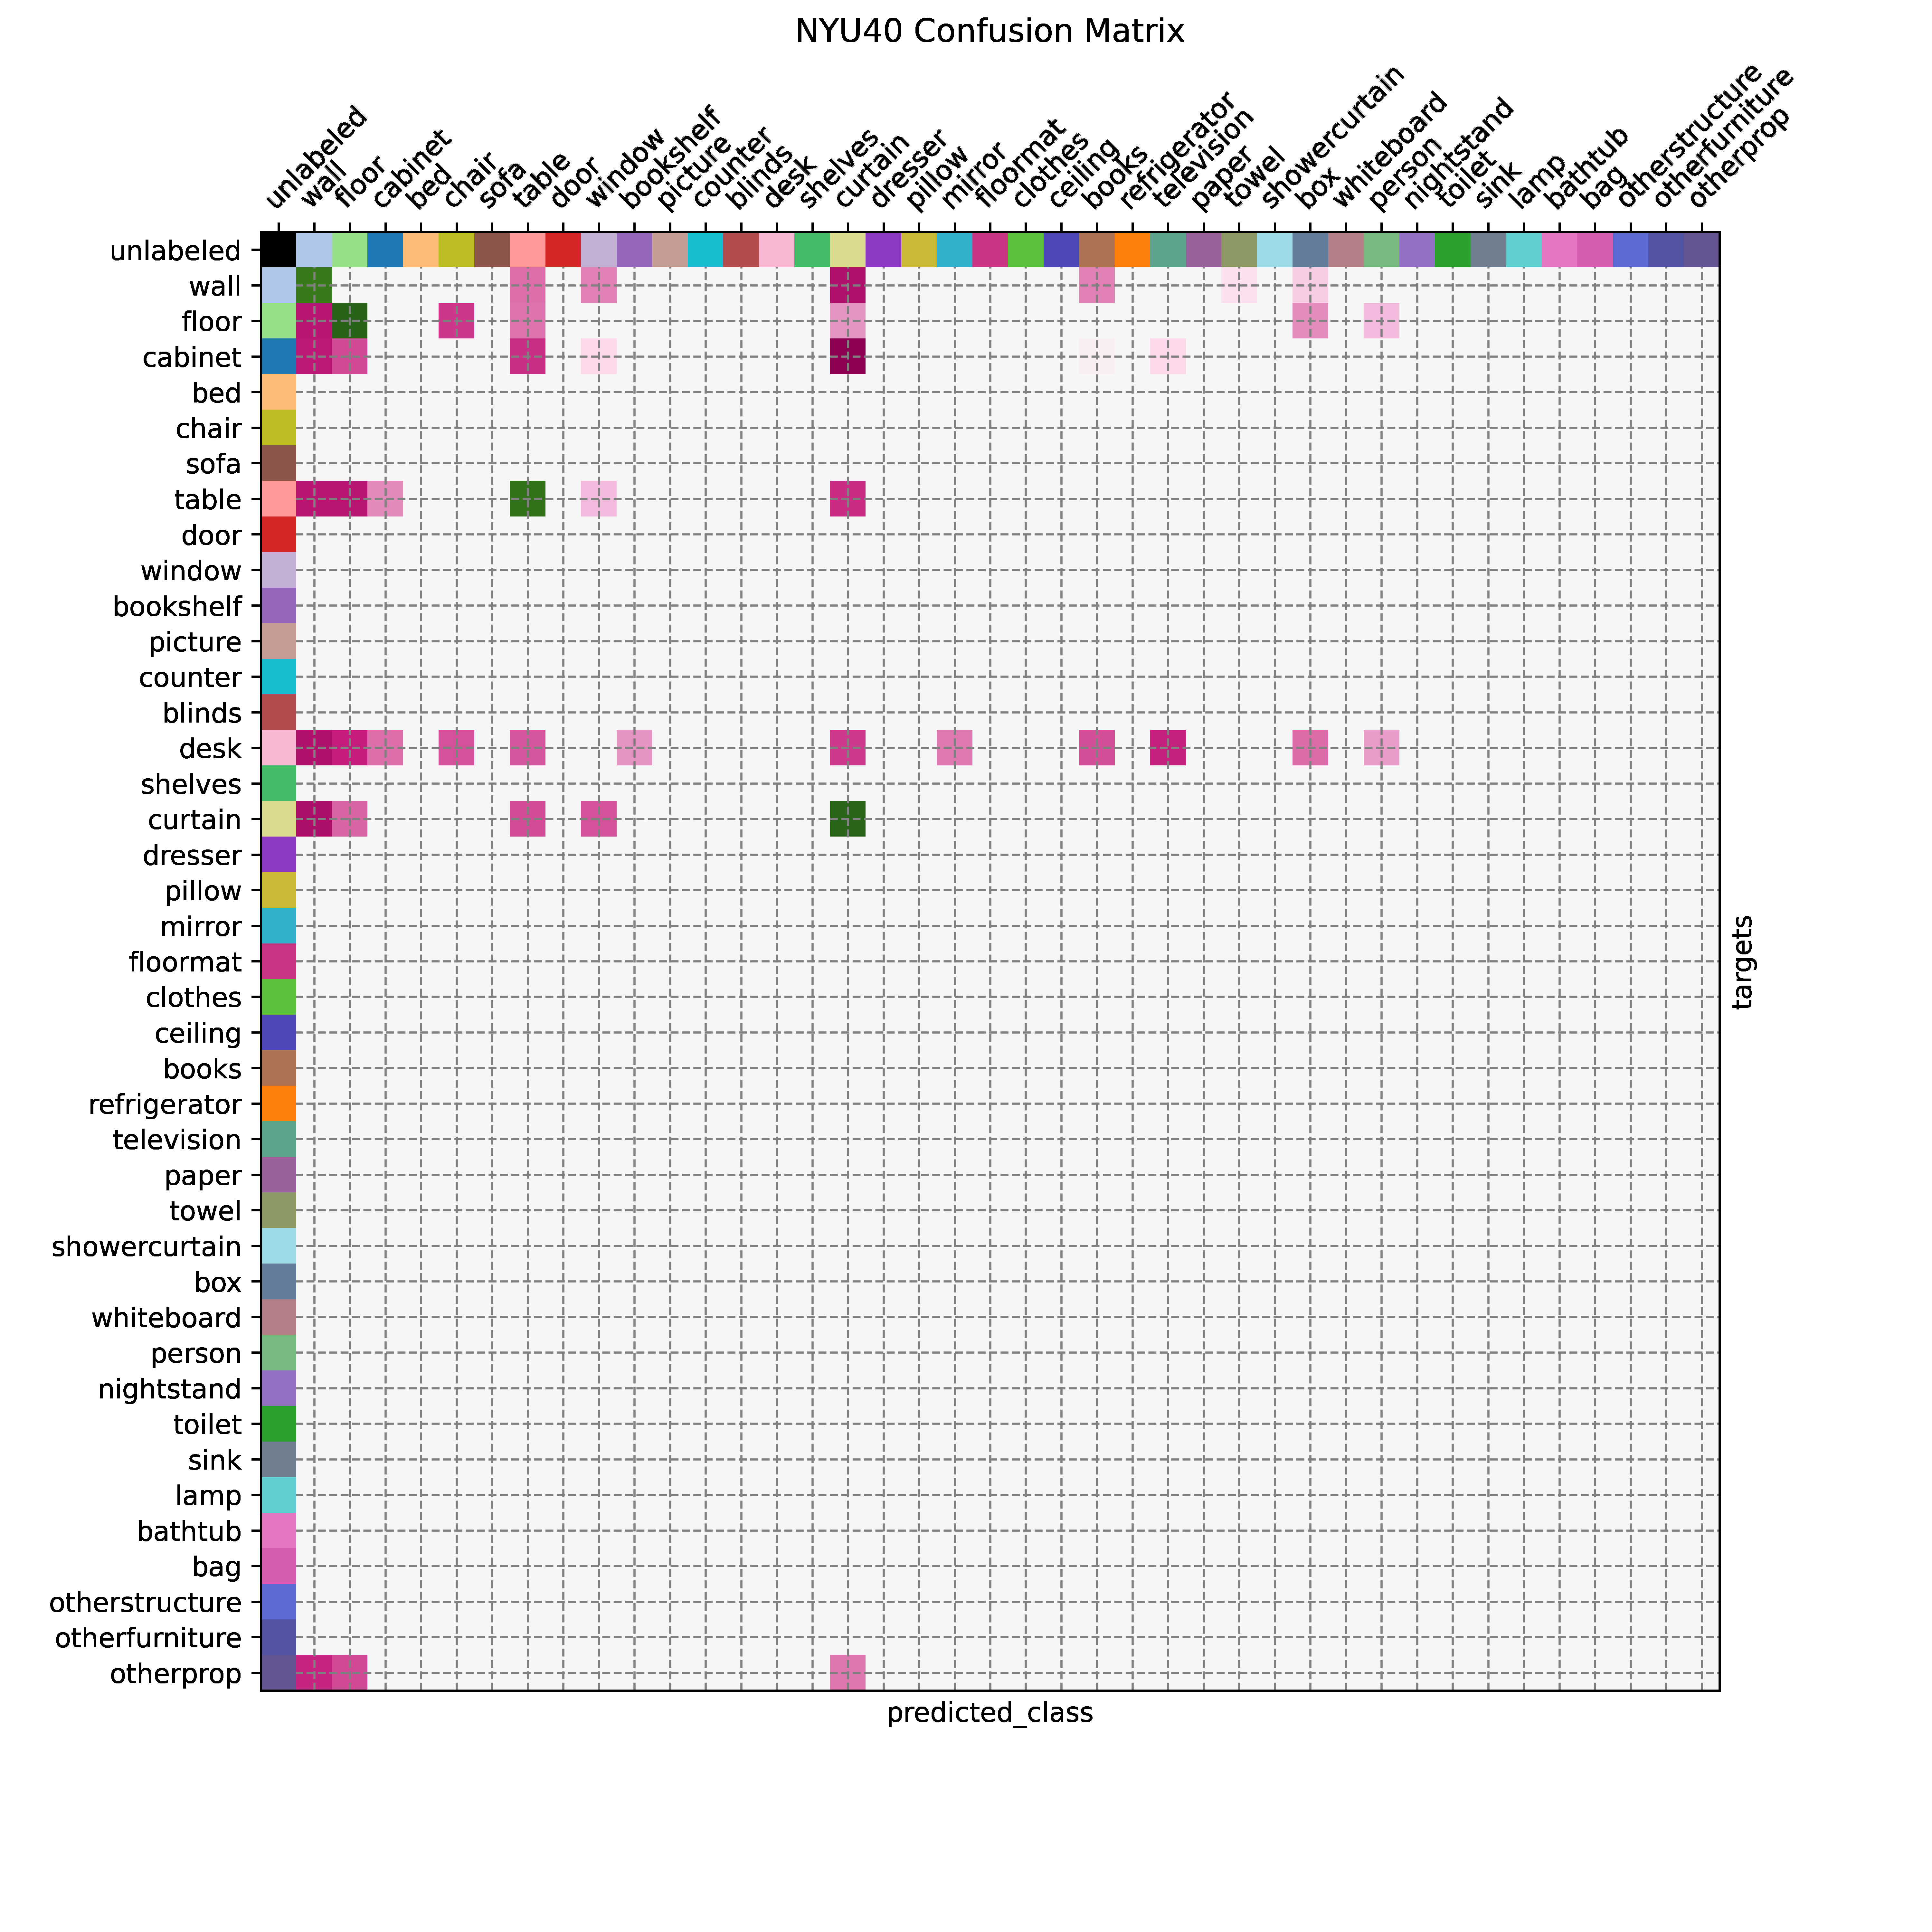

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [74]:
visu.plot_nyu_confusion_matrix( np.log(sumed+1), title="NYU40 Confusion Matrix", jupyter=True)